# MuseGAN: Polyphonic Music Generation
In 2017, Dong et. al. presented a GAN type framework for multi-track music generation in their work titled [“MuseGAN: Multi-track Sequential Generative Adversarial Networks for Symbolic Music Generation and Accompaniment”](https://arxiv.org/abs/1709.06298)

In this notebook, we will:
+ Prepare a simplified set of generators for a 4 track MuseGAN
+ Train MuseGAN using the [JSB Chorales dataset](https://github.com/czhuang/JSB-Chorales-dataset) presented by [Boulanger-Lewandowsk et. al.](http://www-etud.iro.umontreal.ca/~boulanni/icml2012) 


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PacktPublishing/Hands-On-Generative-AI-with-Python-and-TensorFlow-2/blob/master/Chapter_10/musegan/musegan_simple.ipynb)

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
tf.compat.v1.disable_eager_execution()

In [2]:
import os
import numpy as np
from music21 import converter
import matplotlib.pyplot as plt

In [4]:
from gan_utils import build_critic, build_generator, build_gan, train_musegan
from gan_utils import load_music
from gan_utils import notes_to_midi

## Setup Hyperparameters

In [ ]:
output_folder = 'outputs'
os.mkdir(output_folder)

In [6]:
weight_init = RandomNormal(mean=0., stddev=0.02)
batch_size = 128
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4
grad_weight = 10
z_dim = 32
epochs = 1000
sampling_frequency = 10
n_critic = 5
use_gen = False

## Get Dataset

In [7]:
# get music from this repo
!git clone https://github.com/czhuang/JSB-Chorales-dataset.git

fatal: destination path 'JSB-Chorales-dataset' already exists and is not an empty directory.


In [8]:
# load data
data_path = "JSB-Chorales-dataset/Jsb16thSeparated.npz"
encoded_scores = load_music(data_path, n_bars, n_steps_per_bar)
encoded_scores = np.squeeze(encoded_scores)

In [11]:
input_dim = encoded_scores.shape[1:]
input_dim

(2, 16, 84, 4)

## Prepare Model Objects

+ Critic
+ Generator
+ GAN

In [12]:
critic = build_critic(input_dim, weight_init, n_bars)

In [13]:
gen_model = build_generator(z_dim,
                    n_tracks,
                    n_bars,
                    n_steps_per_bar,
                    n_pitches,
                    weight_init)

In [14]:
critic_model, gan_model = build_gan(gen_model,
                                    critic,
                                    input_dim,
                                    z_dim,
                                    n_tracks,
                                    batch_size,
                                    grad_weight)

## Train MuseGAN

In [15]:
d_losses, g_losses = train_musegan(encoded_scores,
                                    critic_model,
                                    gen_model,
                                    gan_model,
                                    z_dim,
                                    n_tracks,
                                    n_bars,
                                    n_steps_per_bar,
                                    batch_size,
                                    epochs,
                                    output_folder,
                                    sampling_frequency,
                                    n_critic,
                                    use_gen=use_gen)

Epoch=0 [D loss: (10.0)(Real=-0.0,               Fake=-0.0, Grad.Penalty=1.0)] [Gen loss: 0.0]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch=1 [D loss: (3.8)(Real=-4.9,               Fake=-0.2, Grad.Penalty=0.9)] [Gen loss: -2.7]
Epoch=2 [D loss: (-298.3)(Real=-392.7,               Fake=-6.1, Grad.Penalty=10.0)] [Gen loss: -97.2]
Epoch=3 [D loss: (-196.5)(Real=-205.3,               Fake=-8.1, Grad.Penalty=1.7)] [Gen loss: -63.9]
Epoch=4 [D loss: (-218.6)(Real=-712.7,               Fake=-2.5, Grad.Penalty=49.7)] [Gen loss: -208.1]
Epoch=5 [D loss: (-297.2)(Real=-582.6,               Fake=29.2, Grad.Penalty=25.6)] [Gen loss: -270.9]
Epoch=6 [D loss: (-272.0)(Real=-503.9,               Fake=43.5, Grad.Penalty=18.8)] [Gen loss: -290.5]
Epoch=7 [D loss: (-219.8)(Real=-461.4,               Fake=87.6, Grad.Penalty=15.4)] [Gen loss: -287.8]
Epoch=8 [D loss: (-162.2)(Real=-407.2,               Fake=135.1, Grad.Penalty=11.0)] [Gen loss: -263.3]
Epoch=9 [D loss: (-115.9)(Real=-356.2,               Fake=165.7, Grad.Penalty=7.5)] [Gen loss: -239.9]
Epoch=10 [D loss: (-83.4)(Real=-306.4,               Fake=174.5, Grad.Penalty=4.9)]

## Visualize Training Progress

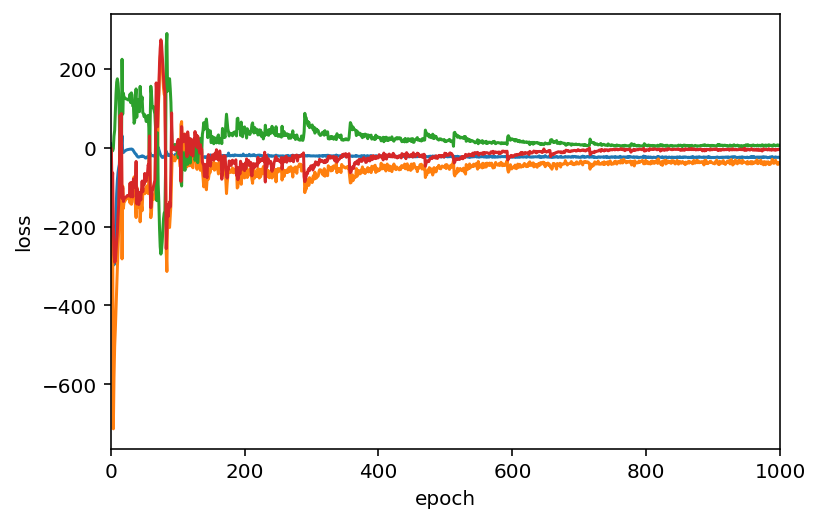

In [16]:
fig = plt.figure()
plt.plot([x[0] for x in d_losses])
plt.plot([x[1] for x in d_losses])
plt.plot([x[2] for x in d_losses])
plt.plot(g_losses)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.xlim(0, len(d_losses))
plt.show()

## Generate Some Music !!!

In [17]:
track1_noise = np.random.normal(0, 1, (1, z_dim))
track2_noise = np.random.normal(0, 1, (1, z_dim))
track3_noise = np.random.normal(0, 1, (1, n_tracks, z_dim))
track4_noise = np.random.normal(0, 1, (1, n_tracks, z_dim))

In [20]:
gen_scores = gen_model.predict([track1_noise, 
                                    track2_noise, 
                                    track3_noise, 
                                    track4_noise])

In [21]:
inference_id = "musegan"
notes_to_midi(n_bars,
              n_steps_per_bar,
              n_tracks,
              inference_id,
              output_folder,
              gen_scores)

In [23]:
gen_score = converter.parse(os.path.join(output_folder, 'sample_musegan_0.midi'))
gen_score.show('text')

{0.0} <music21.stream.Part 0x7fd676d19908>
    {0.0} <music21.tempo.MetronomeMark adagietto Quarter=66.0>
    {0.0} <music21.note.Note G>
    {0.25} <music21.note.Note D>
    {1.0} <music21.note.Note A>
    {2.0} <music21.note.Note D>
    {2.5} <music21.note.Note B>
    {2.75} <music21.note.Note D>
    {3.0} <music21.note.Note A>
    {3.25} <music21.note.Note D>
    {3.5} <music21.note.Note A>
    {3.75} <music21.note.Note B>
    {4.0} <music21.note.Note C>
    {4.75} <music21.note.Note A>
    {5.0} <music21.note.Note C>
    {5.5} <music21.note.Note A>
    {5.75} <music21.note.Note C>
    {6.0} <music21.note.Note C>
    {6.5} <music21.note.Note A>
    {7.0} <music21.note.Note C>
{0.0} <music21.stream.Part 0x7fd676a14278>
    {0.0} <music21.note.Note E>
    {0.25} <music21.note.Note G>
    {1.0} <music21.note.Note A>
    {1.25} <music21.note.Note F>
    {1.5} <music21.note.Note E>
    {2.0} <music21.note.Note G>
    {3.0} <music21.note.Note E>
    {4.0} <music21.note.Note E>
    {4.5} <